In [1]:
!pip install onnxruntime onnx numpy opencv-python pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 374.5 kB/s eta 0:00:000:00:01m eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 391.5 kB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 343.7 kB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 450.7 kB/s eta 0:00:00m eta 0:00:010:00:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 537.2 kB/s eta 0:00:00 kB/s eta 0:00:01:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 531.1 kB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 755.2 kB/s eta 0:00:001m756.6 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 683.8 kB/s eta 0:00:00 kB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 619.1 kB/s eta 0:00:001m617.0 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 700.0 kB/s eta 0:00:0031m? eta -:--:--


In [3]:
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Load the ONNX model
model_path = "yolov9/runs/train-seg/exp/weights/best.onnx"
session = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])

In [4]:
# Load and preprocess the image
def preprocess_image(image_path, img_size=640):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (img_size, img_size))  # Resize to model input size
    image = image / 255.0  # Normalize (0-1)
    image = np.transpose(image, (2, 0, 1))  # Change shape to (C, H, W)
    image = np.expand_dims(image, axis=0).astype(np.float32)  # Add batch dimension
    return image

# Load the test image
image_path = "yolov9/test/test.jpg"
input_image = preprocess_image(image_path)

In [5]:
# Get input and output layer names
input_name = session.get_inputs()[0].name
output_names = [output.name for output in session.get_outputs()]

# Perform inference
outputs = session.run(output_names, {input_name: input_image})

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def postprocess_and_visualize(image_path, boxes, scores, labels, masks, conf_threshold=0.25):
    orig_image = cv2.imread(image_path)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    for i in range(len(scores)):
        x1, y1, x2, y2 = map(int, boxes[i])
        cv2.rectangle(orig_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Resize mask to match image size
        mask = cv2.resize(masks[i], (x2 - x1, y2 - y1))
        mask = mask > 0.5  # Threshold

        # Apply mask to the image
        color = np.random.randint(0, 255, (1, 3), dtype=np.uint8)
        orig_image[y1:y2, x1:x2][mask] = (
            orig_image[y1:y2, x1:x2][mask] * 0.5 + color * 0.5
        ).astype(np.uint8)

    plt.figure(figsize=(8, 8))
    plt.imshow(orig_image)
    plt.axis("off")
    plt.show()

# Call visualization
postprocess_and_visualize(image_path, boxes, scores, labels, masks)


NameError: name 'boxes' is not defined

In [7]:
# Print output details
for i, output in enumerate(outputs):
    print(f"Output {i}: Shape {output.shape}, Type {type(output)}")


Output 0: Shape (1, 38, 8400), Type <class 'numpy.ndarray'>
Output 1: Shape (1, 32, 160, 160), Type <class 'numpy.ndarray'>


Output 0: Shape (1, 38, 8400), Type <class 'numpy.ndarray'>
Output 1: Shape (1, 32, 160, 160), Type <class 'numpy.ndarray'>


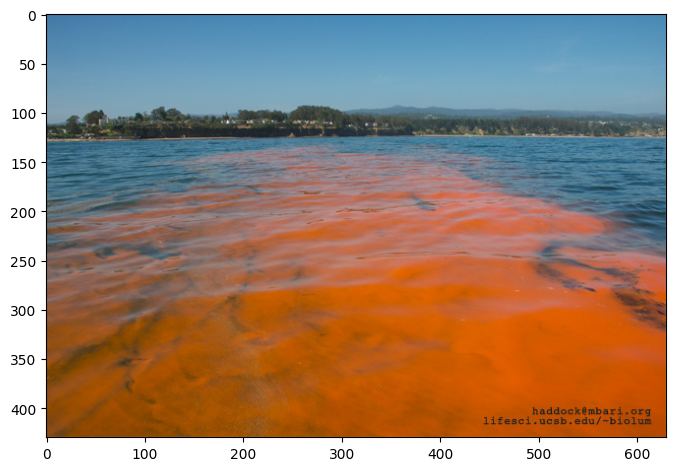

In [9]:
import onnxruntime as ort
import numpy as np
import cv2

# Load ONNX model
session = ort.InferenceSession("yolov9/runs/train-seg/exp/weights/best.onnx")

# Read test image
image_path = "yolov9/test/test.jpg.jane"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
image_resized = cv2.resize(image, (640, 640))  # Resize to model input size
image_resized = image_resized.astype(np.float32) / 255.0  # Normalize

# Prepare input tensor
input_tensor = np.expand_dims(image_resized.transpose(2, 0, 1), axis=0)  # Shape: (1, 3, 640, 640)

# Run inference
outputs = session.run(None, {session.get_inputs()[0].name: input_tensor})

# Print output shapes for debugging
print(f"Output 0: Shape {outputs[0].shape}, Type {type(outputs[0])}")  # Should be (1, 38, 8400)
print(f"Output 1: Shape {outputs[1].shape}, Type {type(outputs[1])}")  # Should be (1, 32, 160, 160)

##

# Extract the first output (bounding boxes, scores, labels, and mask embeddings)
detection_output = outputs[0]  # Shape: (1, 38, 8400)
detection_output = np.squeeze(detection_output, axis=0)  # Remove batch dim -> Shape: (38, 8400)

# Extract bounding boxes (x1, y1, x2, y2)
boxes = detection_output[:4, :].T  # Shape: (8400, 4)

# Extract objectness scores
objectness = detection_output[4, :]  # Shape: (8400,)

# Extract class probabilities & get the best class
class_scores = detection_output[5:6, :]  # Assuming only 1 class for instance segmentation
scores = objectness * class_scores.squeeze(0)  # Final confidence score
labels = np.zeros_like(scores, dtype=int)  # Assuming single-class model

# Keep only high-confidence detections
conf_threshold = 0.25
keep = scores > conf_threshold
boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

# Extract mask embeddings (32D vector per detection)
mask_embeddings = detection_output[6:38, :].T  # Shape: (8400, 32)
mask_features = outputs[1]  # Shape: (1, 32, 160, 160)
mask_features = np.squeeze(mask_features, axis=0)  # Remove batch dim -> Shape: (32, 160, 160)

# Multiply embeddings with feature map to get instance masks
masks = np.matmul(mask_embeddings, mask_features.reshape(32, -1))  # Shape: (8400, 25600)
masks = masks.reshape(-1, 160, 160)  # Reshape to (num_detections, 160, 160)

# Keep only masks for selected detections
masks = masks[keep]

##

import matplotlib.pyplot as plt

def postprocess_and_visualize(image_path, boxes, scores, labels, masks, conf_threshold=0.25):
    orig_image = cv2.imread(image_path)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    for i in range(len(scores)):
        x1, y1, x2, y2 = map(int, boxes[i])
        cv2.rectangle(orig_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Resize mask to match image size
        mask = cv2.resize(masks[i], (x2 - x1, y2 - y1))
        mask = mask > 0.5  # Threshold

        # Apply mask to the image
        color = np.random.randint(0, 255, (1, 3), dtype=np.uint8)
        orig_image[y1:y2, x1:x2][mask] = (
            orig_image[y1:y2, x1:x2][mask] * 0.5 + color * 0.5
        ).astype(np.uint8)

    plt.figure(figsize=(8, 8))
    plt.imshow(orig_image)
    plt.axis("on")
    plt.show()

# Now call the function
postprocess_and_visualize(image_path, boxes, scores, labels, masks)
